In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy, collections 
import matplotlib as mpl
import matplotlib.pyplot as plt

import os, re, glob, time
import itertools, collections
import librosa, pickle

random_state = 2020
plt.style.use('seaborn-darkgrid')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

# Extract Features from Wave Files

In [4]:
## Directory Path
train_dir='../Data_large/nsynth-train/audio/'

valid_dir='../Data_large/nsynth-valid/audio/'

test_dir='../Data_large/nsynth-test/audio/'

In [5]:
## Read in Train
df_train_raw = pd.read_json(path_or_buf='../Data_large/nsynth-train/examples.json', orient='index')
df_train_raw.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
guitar_acoustic_001-082-050,16629,16000,82,0,guitar,guitar_acoustic_001,guitar_acoustic_001-082-050,[percussive],acoustic,50,3,39,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
bass_synthetic_120-108-050,168243,16000,108,2,bass,bass_synthetic_120,bass_synthetic_120-108-050,[percussive],synthetic,50,0,881,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
organ_electronic_120-050-127,88495,16000,50,1,organ,organ_electronic_120,organ_electronic_120-050-127,[],electronic,127,6,979,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
guitar_electronic_021-026-025,146382,16000,26,1,guitar,guitar_electronic_021,guitar_electronic_021-026-025,"[fast_decay, percussive]",electronic,25,3,346,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
organ_electronic_011-079-075,244275,16000,79,1,organ,organ_electronic_011,organ_electronic_011-079-075,[bright],electronic,75,6,188,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [6]:
## Get a count of instruments in ascending order
n_class_train= df_train_raw['instrument_family'].value_counts()
print(n_class_train) 

0     65474
4     51821
6     34477
5     34201
3     32690
8     19474
7     13911
1     12675
10    10208
2      8773
9      5501
Name: instrument_family, dtype: int64


In [7]:
## Sample 
df_train_sample = df_train_raw.groupby('instrument_family', as_index=False, group_keys=False).apply(lambda df: df.sample(2000, replace=True, random_state = random_state))

## Dropping Synth Lead 
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]

df_train_sample.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_100-073-025,284251,16000,73,2,bass,bass_synthetic_100,bass_synthetic_100-073-025,[dark],synthetic,25,0,813,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_019-103-075,287063,16000,103,2,bass,bass_synthetic_019,bass_synthetic_019-103-075,"[fast_decay, percussive]",synthetic,75,0,286,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
bass_synthetic_003-033-127,232099,16000,33,2,bass,bass_synthetic_003,bass_synthetic_003-033-127,[distortion],synthetic,127,0,31,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_electronic_019-059-127,237232,16000,59,1,bass,bass_electronic_019,bass_electronic_019-059-127,[],electronic,127,0,771,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_094-030-025,191098,16000,30,2,bass,bass_synthetic_094,bass_synthetic_094-030-025,[dark],synthetic,25,0,781,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


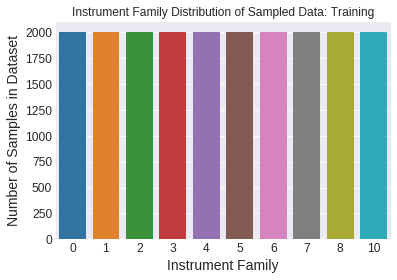

In [8]:
## Display instrument distrution
sns.countplot(x='instrument_family', data = df_train_sample)
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [9]:
## Save the train file index as list
filenames_train = df_train_sample.index.tolist()

## Save the list to a pickle file
with open('../DataWrangling/filenames_train.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

In [10]:
## Extract the filenames from the validation dataset
df_valid = pd.read_json(path_or_buf='../Data_large/nsynth-valid/examples.json', orient='index')

## Save Index as List
filenames_valid = df_valid.index.tolist()

## Save to a pickle
with open('../DataWrangling/filenames_valid.pickle', 'wb') as f:
    pickle.dump(filenames_valid, f)

In [11]:
## Extract the filenames from the test dataset
df_test = pd.read_json(path_or_buf='../Data_large/nsynth-test/examples.json', orient='index')

## Save Index as List
filenames_test = df_test.index.tolist()

## Save to a pickle
with open('../DataWrangling/filenames_test.pickle', 'wb') as f:
    pickle.dump(filenames_test, f)

In [12]:
def feature_extract(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

#### Reference: https://medium.com/@nadimkawwa/can-we-guess-musical-instruments-with-machine-learning-afc8790590b8

## Training Set

In [13]:
start_train = time.time()

## Create Dictionary to store features
dict_train = {}

## Loop Over Every File 
for file in filenames_train:

    ## Extract 
    features = feature_extract(train_dir+ file + '.wav')
    
    ## Add to Dictionary 
    dict_train[file] = features

end_train=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train), end_train - start_train))

Time to extract 20000 files is 6841.043258905411 seconds


In [14]:
## Convert Dictionary to DF
features_train = pd.DataFrame.from_dict(dict_train, orient='index',columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])
features_train.head()

## MFCC
mfcc_train = pd.DataFrame(features_train.mfcc.values.tolist(),
                          index=features_train.index)
mfcc_train = mfcc_train.add_prefix('mfcc_')

## Spectro
spectro_train = pd.DataFrame(features_train.spectro.values.tolist(),
                             index=features_train.index)
spectro_train = spectro_train.add_prefix('spectro_')


## Chroma
chroma_train = pd.DataFrame(features_train.chroma.values.tolist(),
                            index=features_train.index)
chroma_train = chroma_train.add_prefix('chroma_')


## Contrast
contrast_train = pd.DataFrame(features_train.contrast.values.tolist(),
                              index=features_train.index)
contrast_train = chroma_train.add_prefix('contrast_')

## Drop 
features_train = features_train.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

## Concatenate
df_features_train=pd.concat([features_train, mfcc_train, spectro_train, chroma_train, contrast_train],
                           axis=1, join='inner')
df_features_train.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_100-073-025,0,-459.621887,60.604553,15.707026,-0.791278,-13.116416,-41.788025,-63.405979,-58.565708,-28.426939,...,0.520378,0.171801,0.009984,0.005906,0.007431,0.008824,0.011528,0.007292,0.007329,0.206453
bass_synthetic_019-103-075,0,-579.954041,3.348595,0.447090,0.397642,0.574816,0.466731,0.322731,0.171821,0.178293,...,0.144734,0.032572,0.034395,0.093217,0.022438,0.064349,0.047141,0.008865,0.052626,0.038116
bass_synthetic_003-033-127,1,-275.393677,126.373802,-30.129364,36.144222,-5.314821,19.216272,0.425906,5.046715,4.372057,...,0.099953,0.145444,0.258658,0.118536,0.031173,0.126935,0.371510,0.590870,0.405639,0.116591
bass_electronic_019-059-127,1,-495.478546,64.959259,22.378494,10.836192,1.621737,-4.112292,-8.164826,-3.958625,-4.771589,...,0.105775,0.055345,0.048271,0.007574,0.030186,0.064552,0.030623,0.054456,0.483882,0.608856
bass_synthetic_094-030-025,0,-427.515625,62.093185,56.552708,48.755554,40.263329,32.399586,25.919132,20.958433,17.209757,...,0.064196,0.049489,0.067749,0.506897,0.633417,0.458564,0.032357,0.061549,0.020015,0.011788


In [15]:
targets_train = []
for name in df_features_train.index.tolist():
    targets_train.append(instrument_code(name))

df_features_train['targets'] = targets_train

## Save features
with open('../DataWrangling/df_features_train.pickle', 'wb') as f:
    pickle.dump(df_features_train, f)
    
print("Train Features DF shape: ", df_features_train.shape)

Train Features DF shape:  (19012, 167)


## Testing Set

In [16]:
start_test = time.time()

## Create Dictionary to store features
dict_test = {}

## Loop Over Every File 
for file in filenames_test:

    ## Extract
    features = feature_extract(test_dir+ file + '.wav') 
    
    ## Add to Dictionary 
    dict_test[file] = features

end_test=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_test), end_test - start_test))

Time to extract 4096 files is 1403.7911567687988 seconds


In [17]:
## Convert Dictionary to DF 
features_test = pd.DataFrame.from_dict(dict_test, orient='index', columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_068-049-025,1,"[-522.72943, 46.736294, 34.339527, 24.795486, ...","[0.01243889, 0.03493669, 0.05412165, 0.1133079...","[0.4305170426566291, 0.6118004906612967, 0.531...","[36.02463102901302, 29.189569835549623, 27.923..."
keyboard_electronic_001-021-127,0,"[-444.47232, 193.923, 27.263935, -3.6587684, 6...","[0.05536796, 0.20126803, 11.740297, 20.38546, ...","[0.09875436329860442, 0.0874664479879011, 0.22...","[19.98616995783884, 19.848647976797974, 18.847..."
guitar_acoustic_010-066-100,0,"[-439.22327, 59.5869, 2.856642, -12.013889, -1...","[0.0014018335, 0.0033172453, 0.003231407, 0.00...","[0.10204152262987645, 0.08729932552313621, 0.1...","[12.663278303311465, 34.85709984415947, 35.682..."
reed_acoustic_037-068-127,1,"[-373.12695, 69.24476, -39.842648, -21.835655,...","[0.00014625567, 0.00046414713, 0.00040755977, ...","[0.035564534598694304, 0.01759427984279788, 0....","[19.59830865864867, 25.61093047441007, 30.8095..."
flute_acoustic_002-077-100,1,"[-364.7719, 12.806338, -43.040794, 20.029762, ...","[4.9342376e-05, 0.00012846649, 0.00046173763, ...","[0.04172566939402538, 0.06470235645211833, 0.0...","[20.584888239106107, 10.534722127065601, 40.32..."


In [18]:
## Mfccs
mfcc_test = pd.DataFrame(features_test.mfcc.values.tolist(),index=features_test.index)
mfcc_test = mfcc_test.add_prefix('mfcc_')

## Spectro
spectro_test = pd.DataFrame(features_test.spectro.values.tolist(),index=features_test.index)
spectro_test = spectro_test.add_prefix('spectro_')


## Chroma
chroma_test = pd.DataFrame(features_test.chroma.values.tolist(),index=features_test.index)
chroma_test = chroma_test.add_prefix('chroma_')


## Contrast
contrast_test = pd.DataFrame(features_test.contrast.values.tolist(),index=features_test.index)
contrast_test = chroma_test.add_prefix('contrast_')

## Drop
features_test = features_test.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

## Concatenate
df_features_test=pd.concat([features_test, mfcc_test, spectro_test, chroma_test, contrast_test],
                           axis=1, join='inner')
df_features_test.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_068-049-025,1,-522.729431,46.736294,34.339527,24.795486,17.434052,10.184166,4.615236,1.382405,-1.030897,...,0.531641,0.071409,0.006032,0.009253,0.014782,0.088950,0.102427,0.057437,0.010675,0.015779
keyboard_electronic_001-021-127,0,-444.472321,193.923004,27.263935,-3.658768,6.277334,8.114609,10.280761,6.098136,2.501385,...,0.221133,0.499389,0.431473,0.198991,0.186381,0.236050,0.402581,0.323163,0.029404,0.035821
guitar_acoustic_010-066-100,0,-439.223267,59.586899,2.856642,-12.013889,-12.567639,-11.456202,-12.535886,-20.437632,-19.245022,...,0.117914,0.085754,0.028640,0.436033,0.597927,0.473510,0.048822,0.025008,0.022679,0.004659
reed_acoustic_037-068-127,1,-373.126953,69.244759,-39.842648,-21.835655,-50.256344,-16.613256,-29.648701,-16.945005,-17.307316,...,0.046978,0.167250,0.068995,0.016955,0.015628,0.484009,0.655115,0.511854,0.013283,0.006798
flute_acoustic_002-077-100,1,-364.771912,12.806338,-43.040794,20.029762,-29.663240,-21.343328,-18.221209,-9.669495,7.875897,...,0.065065,0.046880,0.490144,0.651743,0.489015,0.026294,0.016009,0.024021,0.037190,0.025133


In [19]:
targets_test = []
for name in df_features_test.index.tolist():
    targets_test.append(instrument_code(name))

df_features_test['targets'] = targets_test

#save the dataframe to a pickle file
with open('../DataWrangling/df_features_test.pickle', 'wb') as f:
    pickle.dump(df_features_test, f)
    
print("Test Features DF shape: ", df_features_test.shape)

Test Features DF shape:  (4096, 167)


## Validation Set

In [20]:
start_valid = time.time()

## Create Dictionary to store features
dict_valid = {}

## Loop Over Every File 
for file in filenames_valid:

    ## Extract 
    features = feature_extract(valid_dir+ file + '.wav') 
    
    ## Add to Dictionary 
    dict_valid[file] = features

end_valid=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid), end_valid - start_valid))

Time to extract 12678 files is 4306.050206899643 seconds


In [21]:
#convert dict to dataframe
features_valid = pd.DataFrame.from_dict(dict_valid, orient='index', columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid.head()

,harmonic,mfcc,spectro,chroma,contrast
keyboard_acoustic_004-060-025,1,"[-475.05997, 57.904964, 45.39779, 33.65426, 23...","[1.2372668, 2.7320971, 1.0568757, 2.697601, 2....","[0.5894005568313697, 0.4270304137419671, 0.040...","[20.76343497665678, 29.197236348836064, 28.282..."
bass_synthetic_033-050-100,1,"[-423.11716, 69.20058, 45.416584, 22.66452, 8....","[2.3285038, 0.09685665, 0.08090851, 0.06191400...","[0.14050136435242797, 0.390144416711426, 0.566...","[30.683828868410306, 29.58135354073383, 32.844..."
bass_synthetic_009-052-050,0,"[-149.23471, 53.307137, -50.052933, 72.83563, ...","[0.82837975, 0.035471108, 0.03619274, 0.063994...","[0.187415879551152, 0.001908716635199173, 0.00...","[32.311582061214835, 30.70394878499703, 34.818..."
keyboard_electronic_003-064-127,0,"[-499.93616, 47.047512, 13.790718, 8.749691, 3...","[0.00079470966, 0.0044926014, 0.01824408, 0.02...","[0.00836718769901377, 0.0008663765722982901, 0...","[17.210256931450676, 29.901833163963854, 30.24..."
bass_synthetic_034-030-050,1,"[-411.42053, 67.55021, 39.09134, 55.981926, 24...","[0.9940757, 5.0609846, 85.64242, 436.8527, 84....","[0.1963821939125205, 0.39260497312668574, 0.17...","[28.277958740735333, 20.29757882984112, 19.941..."


In [22]:
## Mfccs
mfcc_valid = pd.DataFrame(features_valid.mfcc.values.tolist(),
                          index=features_valid.index)
mfcc_valid = mfcc_valid.add_prefix('mfcc_')

## Spectro
spectro_valid = pd.DataFrame(features_valid.spectro.values.tolist(),
                             index=features_valid.index)
spectro_valid = spectro_valid.add_prefix('spectro_')


## Chroma
chroma_valid = pd.DataFrame(features_valid.chroma.values.tolist(),
                            index=features_valid.index)
chroma_valid = chroma_valid.add_prefix('chroma_')


## Contrast
contrast_valid = pd.DataFrame(features_valid.contrast.values.tolist(),
                              index=features_valid.index)
contrast_valid = chroma_valid.add_prefix('contrast_')

## Drop
features_valid = features_valid.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

## Concatenate
df_features_valid=pd.concat([features_valid, mfcc_valid, spectro_valid, chroma_valid, contrast_valid],
                           axis=1, join='inner')
df_features_valid.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
keyboard_acoustic_004-060-025,1,-475.059967,57.904964,45.397789,33.654259,23.840649,16.517649,11.215567,6.625139,2.417870,...,0.040974,0.073346,0.131672,0.167997,0.161846,0.113347,0.113519,0.079041,0.068088,0.413653
bass_synthetic_033-050-100,1,-423.117157,69.200577,45.416584,22.664520,8.433683,1.113607,-2.524592,-3.295073,-2.176944,...,0.566293,0.455566,0.094304,0.046154,0.000859,0.078811,0.052517,0.089218,0.088820,0.051163
bass_synthetic_009-052-050,0,-149.234711,53.307137,-50.052933,72.835632,-48.004280,37.524715,-38.533348,19.412514,-23.413315,...,0.003888,0.469621,0.677325,0.452823,0.001909,0.000000,0.000000,0.000000,0.134581,0.247741
keyboard_electronic_003-064-127,0,-499.936157,47.047512,13.790718,8.749691,3.253123,-1.371571,-5.380596,-7.059535,-8.347107,...,0.004917,0.405893,0.545605,0.458490,0.088808,0.154312,0.144893,0.064207,0.038475,0.023381
bass_synthetic_034-030-050,1,-411.420532,67.550209,39.091339,55.981926,24.597698,26.598867,12.040562,12.276508,6.266153,...,0.179437,0.076811,0.076412,0.359199,0.504694,0.410889,0.082257,0.003461,0.082358,0.065493


In [23]:
targets_valid = []
for name in df_features_valid.index.tolist():
    targets_valid.append(instrument_code(name))

df_features_valid['targets'] = targets_valid

df_features_valid.shape

#save the dataframe to a pickle file
with open('../DataWrangling/df_features_valid.pickle', 'wb') as f:
    pickle.dump(df_features_valid, f)
    
print("Valid Features DF shape: ", df_features_valid.shape)

Valid Features DF shape:  (12678, 167)


# Clean JSON Files

### 1. Train

In [ ]:
## Extract Qualities 
train_qual = pd.DataFrame(df_train_sample.qualities.values.tolist(), index= df_train_sample.index)

## Concatenate
json_train=pd.concat([df_train_sample, train_qual],
                           axis=1, join='inner')

json_train= json_train.drop(labels=['qualities'], axis=1)

## Save to Pickle 
with open('../DataWrangling/json_train.pickle', 'wb') as f:
    pickle.dump(json_train, f)

### 2. Test

In [24]:
#extract qualities
test_qual = pd.DataFrame(df_test.qualities.values.tolist(), index= df_test.index)


#concatenate
json_test=pd.concat([df_test, test_qual],
                           axis=1, join='inner')

json_test= json_test.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('../DataWrangling/json_test.pickle', 'wb') as f:
    pickle.dump(json_test, f)

### 3. Valid

In [25]:
#extract qualities
valid_qual = pd.DataFrame(df_valid.qualities.values.tolist(), index= df_valid.index)


#concatenate
json_valid=pd.concat([df_valid, valid_qual],
                           axis=1, join='inner')

json_valid= json_valid.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('../DataWrangling/json_valid.pickle', 'wb') as f:
    pickle.dump(json_valid, f)